In [335]:
import awkward as ak
import numpy as np
import time
import coffea
import uproot
import hist
import vector
print("awkward version ", ak.__version__)
print("coffea version ", coffea.__version__)
from coffea import util, processor
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema
from collections import defaultdict
import pickle
from distributed.diagnostics.plugin import UploadDirectory
import os

awkward version  1.10.3
coffea version  0.7.21


In [337]:
class QCDProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.axis.StrCategory([], growth=True, name="dataset", label="Primary dataset")
        frac_axis = hist.axis.Regular(150, 0, 2.0, name="frac", label=r"Fraction")
        ptgen_axis = hist.axis.Variable([200,260,350,460,550,650,760,13000], name="ptgen", label=r"p_{T,RECO} (GeV)")
        n_axis = hist.axis.Regular(5, 0, 5, name="n", label=r"Number")
        pt_axis = hist.axis.Variable([
                                     100,120,140,160,180,
                                     200,250,300,350,400,450,500,
                                     600,700,800,900,1000,
                                     1500,2000,3000,4000,5000], name="pt", label=r"$p_{T}$ [GeV]")
        pileup_axis = hist.axis.Regular(10,0,100, name = "pileup", label = r"$\mu$" )
        
        eta_axis = hist.axis.Regular(150, -6,6, name = "eta", label = r"$eta$")

        h_njet_gen = hist.Hist(dataset_axis, n_axis, storage="weight", label="Counts")
        h_njet_reco = hist.Hist(dataset_axis, n_axis, storage="weight", label="Counts")
        
        h_pt_reco_over_gen = hist.Hist( dataset_axis, pt_axis,n_axis, frac_axis, eta_axis, storage = "weight", label = "Counts")
        
        cutflow = {}
        
        self.hists = {
            "njet_gen":h_njet_gen,
            "njet_reco":h_njet_reco,
            "pt_reco_over_gen": h_pt_reco_over_gen,
            "cutflow":cutflow
        }
        
    @property
    def accumulator(self):
        return self.hists
    
    def process(self, events):
        dataset = events.metadata['dataset']
        
        if dataset not in self.hists["cutflow"]:
            self.hists["cutflow"][dataset] = defaultdict(int)
            


        gen_vtx = events.GenVtx.z
        reco_vtx = events.PV.z
        
        
        # delta_z < 0.2 between reco and gen
        events = events[np.abs(gen_vtx - reco_vtx) < 0.2]
        
        
        # loose jet ID
        events.Jet = events.Jet[events.Jet.jetId > 0]
        
        # get a tight gen match
        events.Jet = events.Jet[~ak.is_none(events.Jet.matched_gen, axis=1)]
        events.Jet = events.Jet[events.Jet.delta_r(events.Jet.matched_gen) < 0.2]
        events = events[ak.num(events.Jet) > 0 ]
        dataset = events.metadata['dataset']
        
        # take leading 3 jets. If there are 2 jets, the third entry will be None so we will remove them below
        recojets = events.Jet[:,0:3]
        genjets = recojets.matched_gen        
        ptresponse = recojets.pt/genjets.pt
        
        n_reco_vtx = events.PV.npvs #the number of primary vertices

        sel = ~ak.is_none(ptresponse,axis=1)
        ptresponse = ptresponse[sel]
        recojets = recojets[sel]
        genjets = genjets[sel]
        
        sel2 = ak.num(ptresponse) > 2
        
        recojets = recojets[sel2]
        genjets = genjets[sel2]
        ptresponse = ptresponse[sel2]
        n_reco_vtx = n_reco_vtx[sel2]
        n_reco_vtx = ak.broadcast_arrays(n_reco_vtx, recojets.pt)[0]
        
#         print("num of ptresponse", ak.num(ptresponse))
#         #weights = np.ones(np.shape(recojets.pt))
        
        
#         print("recojets pt", recojets.pt)
#         print("ptresponse", ptresponse)
#         print("n_reco_vtx", n_reco_vtx)
        
#         print("len_recojet_flattened", len(ak.flatten(recojets.pt)))
#         print("len_n", len(n_reco_vtx))
#         print("len_dataset", len(dataset))
#         print("dataset", dataset)
#         print("len_recojet", len(recojets.pt))
        
        self.hists["pt_reco_over_gen"].fill( dataset = dataset, pt = ak.flatten(genjets.pt), n = ak.flatten(n_reco_vtx) ,frac = ak.flatten(ptresponse), eta = ak.flatten(genjets.eta))
            
        return self.hists
    
    def postprocess(self, accumulator):
        return accumulator
        

In [395]:
fileset = {}
filedir = "samples/"
prependstr = "/mnt/data/cms"


eras_mc = [
        'UL16NanoAODv9', 
        'UL16NanoAODAPVv9',
        'UL17NanoAODv9', 
        'UL18NanoAODv9'
    ]



qcd_mc_filestr = "QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8_"

for era in eras_mc:
    fileset[era] = {}
    filename = filedir + qcd_mc_filestr + era + ".txt"
    with open(filename) as f:
        dy_mc_files = [prependstr + i.rstrip() for i in f.readlines() if i[0] != "#" ]
        fileset[era] = dy_mc_files

In [339]:
#skimmed_fileset

fileset = {'UL16NanoAODv9':['/mnt/data/cms/store/mc/RunIISummer20UL16NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/skimmed/skimmed_total.root'], 
        'UL16NanoAODAPVv9':['/mnt/data/cms/store/mc/RunIISummer20UL16NanoAODAPVv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/106X_mcRun2_asymptotic_preVFP_v11-v1/skimmed/skimmed_total.root'],
        'UL17NanoAODv9':['/mnt/data/cms/store/mc/RunIISummer20UL17NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/106X_mc2017_realistic_v9-v2/skimmed/skimmed_total.root'], 
        'UL18NanoAODv9':['/mnt/data/cms/store/mc/RunIISummer20UL18NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/skimmed/skimmed_total.root']}

In [340]:
# #test 


#fileset = {'UL18NanoAODv9': ['/mnt/data/cms/store/mc/RunIISummer20UL18NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/2540000/894A5559-C6A2-7347-9C7C-2FB1EDDCCEA1.root']}

In [341]:
run = processor.Runner(
            executor = processor.FuturesExecutor(compression = None, workers = 8),
            schema=NanoAODSchema,
            chunksize=1000000,
            maxchunks=None,
            skipbadfiles=True
        )

In [342]:
output = run(
    fileset,
    "Events",
    processor_instance=QCDProcessor(),
)

fname_out = 'QCDresponse.pkl'

with open(fname_out, "wb") as f:
        pickle.dump( output, f )

Output()

In [343]:
with open("QCDresponse.pkl", "rb") as f:
    output = pickle.load( f )

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7fcf3d0e8d00>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

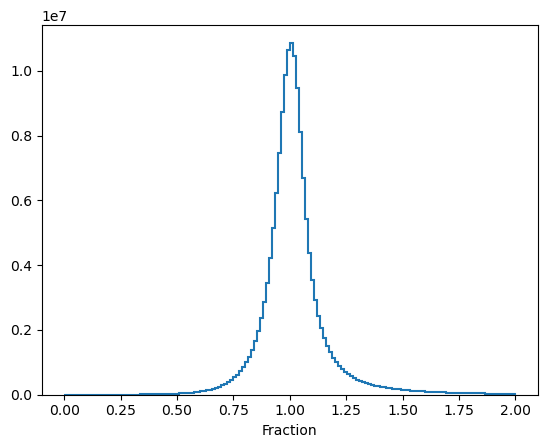

In [344]:
output["pt_reco_over_gen"].project('frac').plot()

In [389]:
hist = output["pt_reco_over_gen"]
dataset_bins = hist.axes[0].edges
pt_bins = hist.axes[1].edges
n_PV_bins = hist.axes[2].edges
frac_bins = hist.axes[3].edges
eta_bins = hist.axes[4].edges

### Bin centers

In [346]:
pt_values = hist.axes[1].centers
n_PV_values = hist.axes[2].centers
frac_values = hist.axes[3].centers
eta_values = hist.axes[4].centers

In [347]:
hist_np = hist.values()

hist_np.shape

(4, 21, 5, 150, 150)

In [348]:
hist_frac = np.sum(hist_np, axis = (1,2,4))

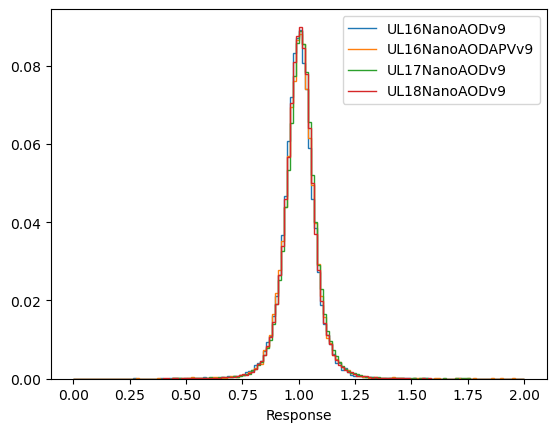

In [349]:
for i in range(4):
    plt.stairs( hist_frac[i]/np.sum(hist_frac[i]),frac_bins,  label = eras_mc[i])
    plt.xlabel("Response")
    plt.legend()

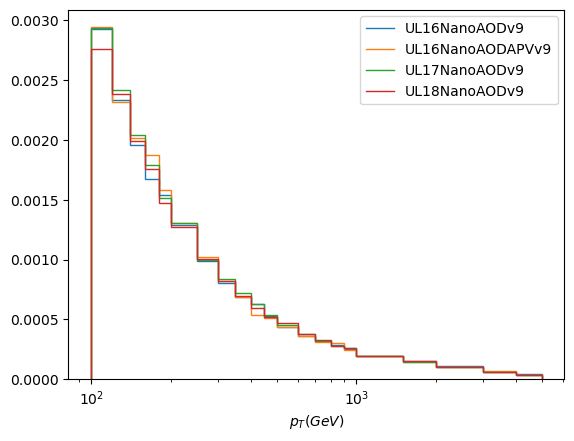

In [394]:
hist_pt = np.sum(hist_np, axis = (2,3,4))
for i in range(4):
    plt.stairs( hist_pt[i]/(np.sum(hist_pt[i])* hist.axes[1].widths),pt_bins,  label = eras_mc[i])
    plt.xlabel(r"$p_T(GeV)$")
    plt.xscale("log")
    plt.legend()

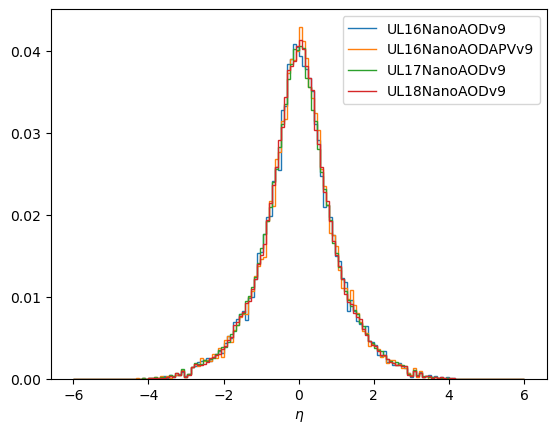

In [351]:
hist_eta = np.sum(hist_np, axis = (1,2,3))
for i in range(4):
    plt.stairs( hist_eta[i]/np.sum(hist_eta[i]),eta_bins,  label = eras_mc[i])
    plt.xlabel(r"$\eta$")
    plt.legend()

In [352]:
hist_frac_pt = np.sum(hist_np, axis = (0,2,4) )

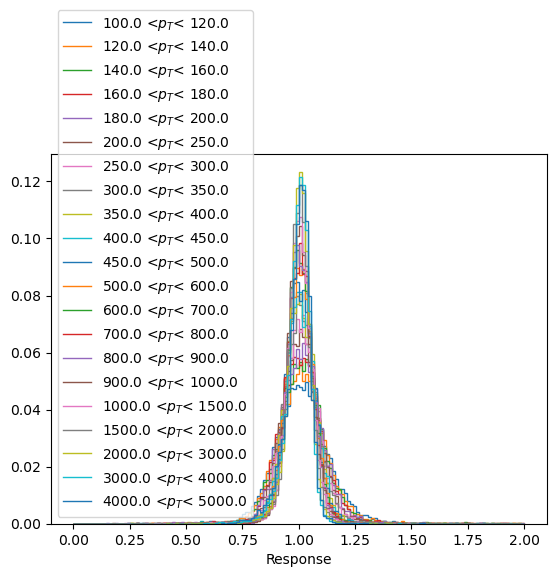

In [353]:
for i in range(21):
    plt.stairs( hist_frac_pt[i]/np.sum(hist_frac_pt[i]),frac_bins,  label = str(pt_bins[i])+r" <$p_T$< "  + str(pt_bins[i+1]) )
    plt.xlabel("Response")
    plt.legend()

In [368]:
from scipy.optimize import curve_fit

class Histfit:
    def __init__(self, hist_frac_pt, frac_values, pt_values):
        self.frac_values = frac_values
        self.hist_frac_pt = hist_frac_pt
        self.pt_values = pt_values
        
        self.parameters = {"mean":np.full(len(self.pt_values), None), "sigma": np.full(len(self.pt_values), None), "const":np.full(len(self.pt_values), None),"sigmaErr":np.full(len(self.pt_values), None)}
        
    def gauss(self,x,  x0, sigma,a):
        return (a*(1/(sigma*np.sqrt(2*np.pi)))*np.exp(-(x - x0) ** 2 / (2 * sigma ** 2)))
    
    def fitGauss(self, hist_frac, frac_values):
        parameters, covariance = curve_fit(self.gauss, frac_values, hist_frac) #,bounds = ([0.5,0.05,-5],[2,0.3,20])
        mean = parameters[0]
        sigma = parameters[1]
        const = parameters[2]
        meanErr = covariance[0][0]
        sigmaErr = covariance[1][1]
        return mean,sigma,const, sigmaErr
    
    def initiate_parameters(self):
        for i in range(len(self.hist_frac_pt)):
            hist_frac = hist_frac_pt[i]
            results = self.fitGauss(hist_frac, self.frac_values)
            for j,key in enumerate(self.parameters.keys()):
                self.parameters[key][i] = results[j]
                
    def store_parameters(self):
        self.initiate_parameters()
        for i in range(3):
            for i,hist_frac in enumerate(hist_frac_pt):
                sel = (self.frac_values > (self.parameters["mean"][i] - self.parameters["sigma"][i])) &  (self.frac_values < (self.parameters["mean"][i] + self.parameters["sigma"][i]))
                frac_values = self.frac_values[sel]
                hist_frac = hist_frac[sel]

                results = self.fitGauss(hist_frac, frac_values)
                for j,key in enumerate(self.parameters.keys()):
                    self.parameters[key][i] = results[j]
            
            
        

In [369]:
histfit = Histfit(hist_frac_pt, frac_values, pt_values)

In [370]:
histfit.store_parameters()

Text(0.5, 0, '$p_T$ )GeV')

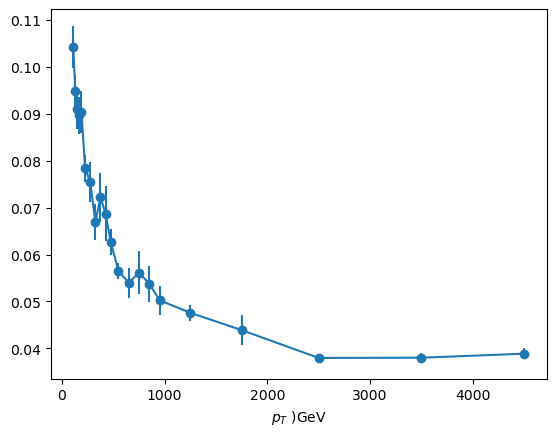

In [387]:
sigma_list = histfit.parameters["sigma"]
sigma_error_list  = histfit.parameters["sigmaErr"]
plt.errorbar(histfit.pt_values, sigma_list, np.power(sigma_error_list, 0.5), marker = 'o')
plt.xlabel(r"$p_T$ )GeV")
#plt.xscale("log")

In [393]:
hist.axes[1].widths

array([  20.,   20.,   20.,   20.,   20.,   50.,   50.,   50.,   50.,
         50.,   50.,  100.,  100.,  100.,  100.,  100.,  500.,  500.,
       1000., 1000., 1000.])